# Description
This project looks to create a CNN classifier on Cats Dogs image Dataset
We will be following along here:
- Build a Deep CNN Image Classifier with ANY Images https://www.youtube.com/watch?v=jztwpsIzEGc
- We will create our own Sequential network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import os
import itertools
import random
import glob
import warnings

2024-08-22 07:50:57.956956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available:  0


# Limit CPU or GPU utilization

In [5]:
gpu = tf.config.experimental.list_physical_devices('GPU')
len(gpu) #Tensorflow only supports NVidia graphs card and not AMD GPUs

0

In [11]:
cpus = tf.config.experimental.list_physical_devices('CPU')
len(cpu)
#for cpu in cpus:
#    tf.config.experimental.set_memory_growth(cpu,True)

2

# Remove corrupted Images

In [3]:
import cv2
#Find alternative to imghdr
import imghdr

/var/folders/yp/nnhfbx9n055106j0nvvkcwlr0000gn/T/ipykernel_2884/1561739119.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = '/Volumes/Datasets/PetImages/clean'
image_exts = ['jpg']

### Remove corrupted images/files

In [4]:
#iterates through each folder
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    
    #skip if not a directory
    if not os.path.isdir(class_path):
        print(f"Skipping {class_path} as it is not a directory")
        continue
    
           
    #iterates through each image in the folder
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            #If not a valid image
            img = cv2.imread(image_path)
            if img is None:
                print(f'issue with image path: {image_path}')
                #Removes image
                os.remove(image_path)
                continue

            #If not a valid image extension
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image.path))
                #Removes image
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
    

KeyboardInterrupt: 

# Import dataset

In [5]:
path = '/Volumes/Datasets/PetImages/clean'
os.chdir(path)

### Specify the classes (folders) you want to include

In [36]:
classes_to_include = ['Cat','Dog']

# Create the dataset including only the specified folders
data = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    class_names=classes_to_include,  # Specify the classes to include
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)

# Print out the included classes to verify
print(f"Included classes: {data.class_names}")

Found 25000 files belonging to 2 classes.
Included classes: ['Cat', 'Dog']


In [37]:
#convert the data to a numpy iterator
data_iterator = data.as_numpy_iterator()
#Select one of the folders
batch = data_iterator.next()


In [38]:
batch[0].shape

(32, 256, 256, 3)

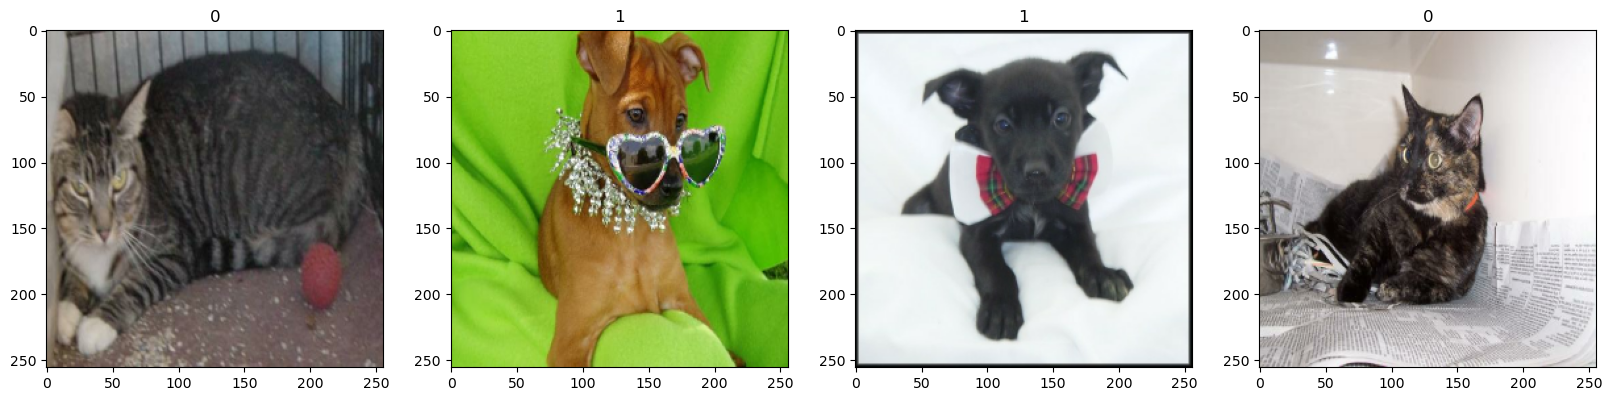

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#Display first 4 images and their class
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


# Preprocessing Data

In [40]:
#Scale Data
#Makes the rgb scale which is from 0 to 255 to 0 to 1 instead for easier processing
data = data.map(lambda x,y: (x/255, y))

In [41]:
#Confirm data is scaled appropriately
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
#Results should be from 0 to 1
batch[0].max(), batch[0].min()

(1.0, 0.0)

### Split Data

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
len(data)

782

In [13]:
train_size = int(len(data)*.7) #70 percent of the data
val_size = int(len(data)*.2) #20% of the data
test_size = int(len(data)*.1)+1 #10 percent of the data +1

In [14]:
#Confirm the total matches the length of the whole dataset
val_size + train_size+ test_size

782

In [15]:
#Allocate a batch of data from dataset to train, val, test sets.
train = data.take(train_size)
val =  data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Deep Model

In [17]:
#Build deep learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [42]:
model = Sequential()

In [43]:
#Convolution scans over image and extracts it.
#16 is number of filters
#(3,3) represents 3 pixels by 3 pixels and check 1 at a time
model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape = (256,256,3)))
#Max pooling condenses the information down. 
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

#Condense the layer down to a single dimension
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss= tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,321 (55.94 KB)

 Trainable params: 14,321 (55.94 KB)

 Non-trainable params: 0 (0.00 B)

### Train data

In [22]:
logdir = 'logs'

In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)

In [47]:
hist = model.fit(train, epochs = 10, validation_data = val, callbacks=[tensorboard_callback], verbose =2)

Epoch 1/10


2024-08-22 08:15:50.869432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_5089]

In [64]:
hist.history

{'accuracy': [0.19886364042758942,
  0.19834710657596588,
  0.19860537350177765,
  0.19860537350177765,
  0.19834710657596588,
  0.1980888396501541,
  0.19938015937805176,
  0.19963842630386353,
  0.19834710657596588,
  0.19834710657596588],
 'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_accuracy': [0.20955882966518402,
  0.21875,
  0.21783088147640228,
  0.21966911852359772,
  0.21599264442920685,
  0.2132352888584137,
  0.20588235557079315,
  0.22794117033481598,
  0.22242647409439087,
  0.2242647111415863],
 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

# Plot performance

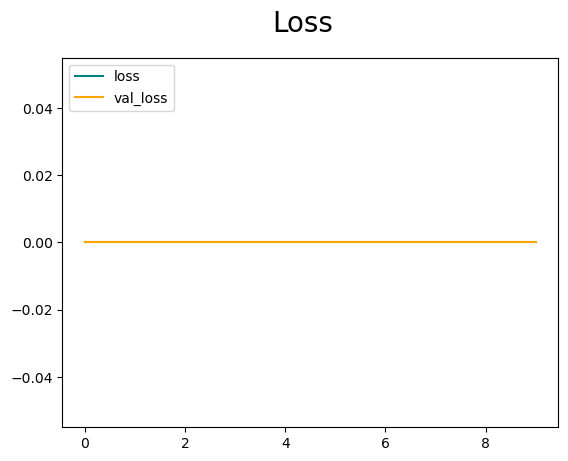

In [65]:
fig = plt.figure()
plt.plot(hist.history['loss'],  color = 'teal', label='loss')
plt.plot(hist.history['val_loss'],  color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()


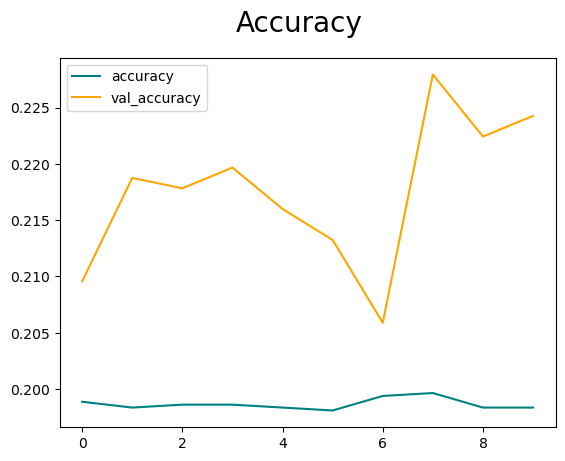

In [66]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],  color = 'teal', label='accuracy')
plt.plot(hist.history['val_accuracy'],  color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

In [67]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [68]:
pre = Precision()
re = Recall()
acc= BinaryAccuracy()

In [69]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


2024-08-12 17:06:51.763212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [70]:
print(f'precision: {pre.result()} Recall: {re.result()} Accuracy: {acc.result()}')

precision: 0.7839285731315613 Recall: 1.0 Accuracy: 0.18571428954601288


# Test

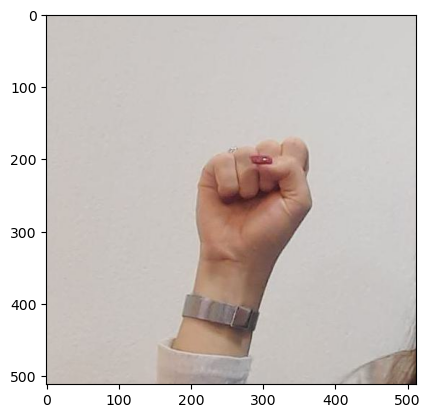

In [73]:
#Import never before seen image
img = cv2.imread('0a8d2460-bcf0-4fd6-9851-25e73eacebd7.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

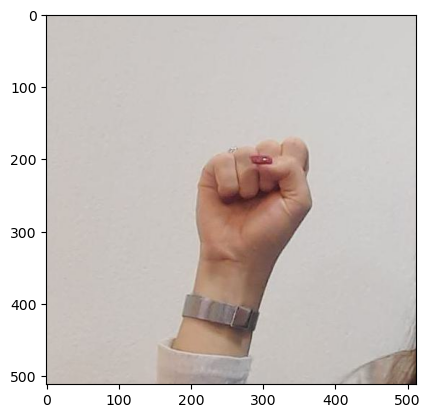

In [78]:
#Resize image
resize = tf.image.resize(img, (224,224))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [79]:
#Predict model
#using np.expand_dims shows the single picture as a batch of pictures as that is what the model expects.
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [80]:
#Since our dataset has more than one class this result tells us nothing
yhat

array([[1.]], dtype=float32)

# Save the model

In [83]:
from tensorflow.keras.models import load_model

In [85]:
#save model, the 'models' parameter creates a folder named models
model.save(os.path.join('models','handgesturemodel.keras'))

In [86]:
#load/import model
new_model = load_model(os.path.join('models', 'handgesturemodel.keras'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [89]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([[1.]], dtype=float32)